# Basics

Before heading into linear regression and the generalized linear model, we introduce some basic notation.

## Data organization

*Structured* data is organized as one or multiple tables. Each row of a table represents an *observation*, each column $X$ a *variable* and each cell a *value*. A value in column $X$ can be viewed as a realization of the *random variable* $X$. 

Examples of *unstructured* data are images, text, audio or video data. We will deal with structured data only.

Throughout this lecture, we will consider the following two data sets:

- `diamonds`: Diamonds prices along with the four "C"-variables: Carat, Color, Cut, and Clarity. Each observation/row represents a diamond.

- `dataCar`: Insurance claim data on vehicle insurance policies from 2004-2005. Some variables like `gender` describe the policy holder, others like `veh_age` the vehicle and some variables carry information on eventual claims. Each row represents a policy.

### Example: diamonds

Let us have look at the first six observations of the diamonds data set.

In [1]:
from plotnine.data import diamonds
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


**Comment:** The data set is neatly structured. It seems to be sorted by price.

## Data types

We distinguish variables by their data type.

- **numerical:** The values of a numerical variable are numbers. Taking sums, means and differences makes sense. Examples: house prices, insurance claim frequencies, blood pressure.
- **categorical:** The values of a categorical variable are categories, e.g. house types, claim types or colors. Depending on whether categories follow a natural order, we talk of *ordered* or *unordered* categoricals. Categories can be encoded by numbers. That does not make the variable numeric though.
- **binary:** A binary variable just takes two values (male/female, yes/no, ...) that can be represented by 1/0. It counts as both numeric and categorical.

Data types are important in determining suitable analysis methods.

### Example: diamonds

In the `diamonds` data set, we will consider the numeric variables `price` and `carat` and the following *ordered* categoricals:

- `color` with ordered categories D < E < F < G < H < I < J,
- `cut` with ordered categories Fair < Good < Very Good < Premium < Ideal, and
- `clarity` with ordered categories I1 < SI2 < SI1 < VS2 < VS1 < VVS2 < VVS1 < IF.

There are no unordered categoricals or binary variables in this data set.

## Descriptive analysis

Statistical modeling always starts with a descriptive analysis of the data. This typically involves a numeric and/or graphical summary of each variable and the most relevant variable pairs, e.g. 

- for numeric variables: mean, standard deviation, quartiles, minimum and maximum; boxplots, mean plots,
- for categorical variables: absolute or relative counts; bar plots,
- for binary variables: like a categorical variable or simply the mean,
- for important pairs of numeric variables: correlations; scatter plots,
- the important pairs of categorical variables: frequency tables; mosaic plots,
- for important pairs of categorical *and* numerical variables: stratified means; mean plots, boxplots.

The more time we invest in the descriptive analysis, the more we learn about the data. Additionally, we might 

- identify data errors and problematic outliers (uncommonly small or large values), 
- find join keys to combine multiple data sources, 
- detect variables with high number of missing values,
- detect variables with no or almost no information (e.g. all values the same),
- **learn how the data is structured** (what *is* a row? do we deal with time series? are rows grouped to clusters etc.),
- ...

During or after the descriptive analysis, we usually do the *data preprocessing* for the modeling task.

### Example: diamonds

Let us summarize the diamonds data set.

#### Univariate description

,price,carat
count,53940.000000,53940.000000
mean,3932.799722,0.797940
std,3989.439738,0.474011
min,326.000000,0.200000
25%,950.000000,0.400000
50%,2401.000000,0.700000
75%,5324.250000,1.040000
max,18823.000000,5.010000


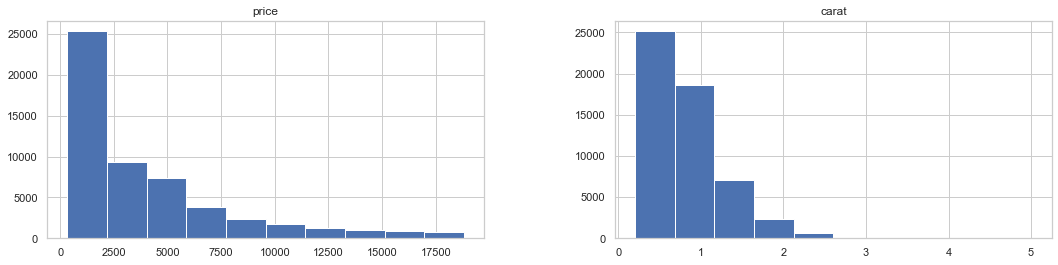

In [72]:
import seaborn as sns
sns.set_theme("notebook", style="whitegrid")
import matplotlib.pyplot as plt

diamonds[["price", "carat"]].hist(figsize=(18, 4))
diamonds[["price", "carat"]].describe()

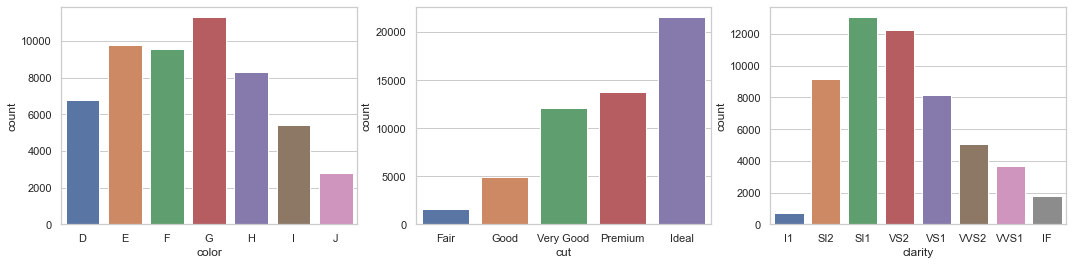

In [73]:
cat_vars = ["color", "cut", "clarity"]

fig, ax = plt.subplots(ncols=3, figsize=(18, 4))
for i, x in enumerate(cat_vars):
    sns.countplot(data=diamonds, x=x, ax=ax[i])

#### Associations with price

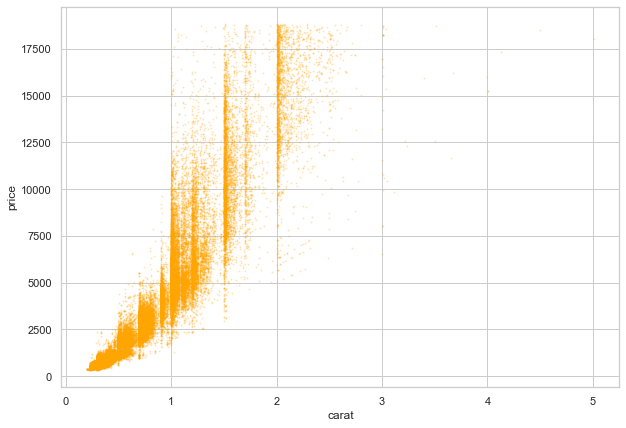

In [64]:
diamonds.plot.scatter(
    x="carat", 
    y="price", 
    alpha=0.2, 
    color="orange",
    s=1, 
    figsize=(10, 7)
);

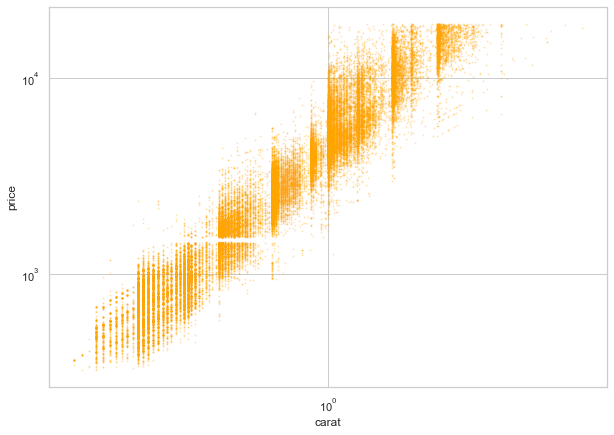

In [65]:
diamonds.plot.scatter(
    x="carat", 
    y="price", 
    loglog=True, 
    alpha=0.2, 
    color="orange",
    s=1, 
    figsize=(10, 7)
);

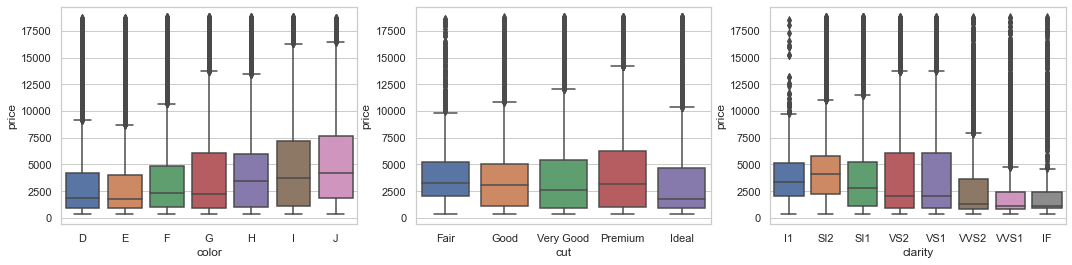

In [74]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 4))
for i, x in enumerate(cat_vars):
    sns.boxplot(data=diamonds, x=x, y="price", ax=ax[i])

**Comments**

- There are 53'940 observations in the diamonds data set.
- The average or mean diamond price is 3933 USD. About half of the diamonds cost less/more than the median of 2401 USD and about half of them cost between 950 USD (first quartile) and 5324 USD (third quartile). The lowest price is 326 USD, the highest price is 18'823 USD.
- Prices and carats show a *right-skewed* distribution with a few very large values.
- The relationship between price and carat seems quite strong and positive, which makes sense. On log-log scale, it looks linear.
- The worst categories of `color`, `cut`, and `clarity` are rare.
- Prices tend to be lower for nice colors, nice cuts as well as for nice clarities. This unintuitive behaviour will be entangled later by our regression models.

## Statistical models

The general modeling task is as follows: we want to approximate a *response variable* $Y$ by a function $f$ of $m$ *covariables* $X_1, \dots, X_m$, i.e.
$$
  Y \approx f(X_1, \dots, X_m).
$$
The function $f$ is unknown and we want to estimate it by $\hat f$ from observed data. 

Note: Think of the response $Y$ and the covariables $X_1, \dots, X_m$ as columns in a data set.

Normally, we are interested in modeling a specific property of $Y$, usually its expectation $E(Y)$ (= theoretic mean). In that case, we can make above approximate relationship more explicit by writing down the *model equation*
$$
  E(Y) = f(X_1, \dots, X_m).
$$

Once found, $\hat f$ serves as our prediction function that can be applied to fresh data. Furthermore, we can investigate the structure of $\hat f$ to gain insights about the relationship between response and covariables: what variables are especially important? how do they influence the response?

**Remark:** Other terms for "response variable" are "output", "target" or "dependent variable". Other terms for "covariable" are "input", "feature", "independent variable" or "predictor".

# Linear Regression

In order to get used to the terms mentioned above, we will look at the mother of all machine learning algorithms: (multiple) linear regression. It was first published by Adrien-Marie Legendre in 1805 [1] and is still very frequently used thanks to its simplicity, interpretability, and flexibility. It further serves as a simple benchmark for more complex algorithms and is the starting point for extensions like the generalized linear model.

## Model equation

The model equation of the linear regression is as follows:
$$
  E(Y) = f(X_1, \dots, X_m) = \beta_0 + \beta_1 X_1 + \cdots + \beta_m X_m.
$$
It relates the covariables $X_1, \dots, X_m$ to the expected response $E(Y)$ by a *linear* formula in the parameters $\beta_0, \dots, \beta_m$. The additive constant $\beta_0$ is called the *intercept*. The parameter $\beta_j$ tells us by how much $Y$ is expected to change when $X_j$ is increased by 1, **keeping all other covariables fixed** ("Ceteris Paribus"). Indeed:
$$
  E(Y \mid X_j = x + 1) - E(Y \mid X_j = x) = \beta_j (x + 1) - \beta_j x = \beta_j.
$$
The parameter $\beta_j$ is called *effect* of $X_j$ on the expected response $E(Y)$.

A linear regression with just one covariable is called a *simple* linear regression with equation 
$$
  E(Y) = \alpha + \beta X.
$$

## Least-squares

The optimal $\hat f$ to estimate $f$ is found by minimizing the sum of squared *prediction errors* resp. *residuals*
$$
  \sum_{i=1}^n e_i^2 = \sum_{i=1}^n (y_i - \hat y_i)^2.
$$
$y_i$ is the observed response of observation $i$ and $\hat y_i$ its prediction (or *fitted value*)
$$
  \hat y_i = \hat f(\text{Values of covariables of observation } i).
$$

Once the model is fitted, we can use the coefficients $\hat\beta_0, \dots, \hat\beta_m$ to make predictions and to study empirical effects of the covariables on the expected response.

### Example: simple linear regression

In order to discuss the typical output of a linear regression, we will now model diamond prices by their size. The model equation is
$$
  E(\text{price}) = \alpha + \beta \cdot \text{carat}.
$$


In [9]:
x_ord = ["cut", "color", "clarity"]
ord_levels = [diamonds[x].cat.categories.to_list() for x in x_ord]
ord_levels

preprocessor = ColumnTransformer(
    transformers=[
        ("log", FunctionTransformer(np.log), ["carat"]),
        ("encoder", OrdinalEncoder(categories=ord_levels), x_ord)
    ],
    remainder="drop"
)

X = preprocessor.fit_transform(diamonds)
X